This is a notebook to implement getting the covariance via a combination of simulations and adding shape noise via sampling from an independent covariance matrix.

In [1]:
import numpy as np
import cov_script as cs
import matplotlib
import matplotlib.pyplot as plt
np.set_printoptions(linewidth=240)
import pyccl as ccl
import add_shape_noise as sn
import specs as sp
import utils as u 
import joint_cov as jp

Get the correlation matrix of Ups_gm, Ups_gg and beta, using Shadab's simulations and my additional shape-noise modelling

First let's get all the jacknife elements with added shape noise:

In [2]:
sims_Lbox = 1380 # Mpc/h
sims_vol = sims_Lbox**3 # (Mpc/h)^3
rp0 = 1.5

lens = 'DESI'
src = 'LSSTY10'

# Let's use the same cosmological parameters as Shadab's simulations:
h=0.69
OmB = 0.022/h**2

#As is selected to match the sigma8 value we are using alongside other parameters. 

params = {'mu_0': 0., 'sigma_0':0., 'OmB':OmB, 'h':h, 'n_s':0.965, 'A_s':2.115 * 10**(-9), 'b':2.33, 'OmM': 0.292} # Intrinsic alignment params? Photo-z params? tau?

cs.Ups_gm_samples_with_shapenoise(sims_vol, rp0, params, lens, src, '../data_for_Danielle/')

nbar*V= 3050882.678623948
SigC2= 3609430.172427447


[ 0.11591284  0.15280288  0.20143342  0.26554097  0.35005117  0.46145732  0.60831922  0.80192091  1.05713764  1.39357881  1.83709466  2.42176242  3.19250463  4.20854074  5.54793718  7.31360558  9.64120984 12.70958983 16.75450244
 22.08673575 29.11598823 38.38234769 50.59778848 66.70087562 87.92887875]


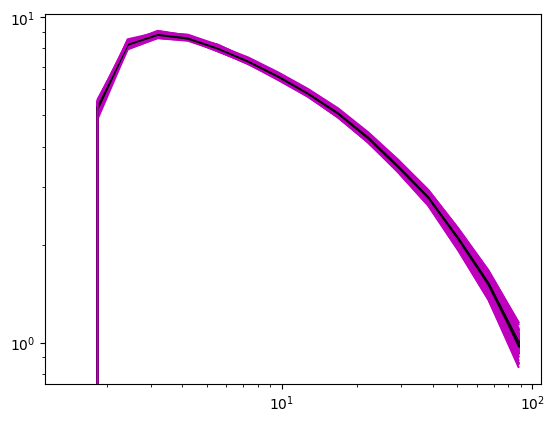

In [3]:
# Check how the jacknife samples look with and without the shape noise added just to make sure it's sensible

up_gm_noSN_file = 'test-HOD-PB00-z0.75-w1pz_cat-zRSD-model-5-gxm-sel-crossparticles-wtag-w1-rfact10-bin1-wp-logrp-pi-NJN-100.txt.upsilon'

ups_jk_noSN = np.loadtxt('../data_for_Danielle/'+up_gm_noSN_file)

ups_jk_noSN_only = ups_jk_noSN[:,4:]

rp = ups_jk_noSN[:,0]

print(rp)

#plt.figure()
#for i in range(0, len(ups_jk_noSN_only[0,:])):
#    plt.loglog(ups_jk_noSN[9:,0], ups_jk_noSN_only[9:,i],'o')
#plt.show()

up_gm_SN_file = 'ups_gm_with_SN_'+lens+'_'+src+'.dat'

ups_jk_SN = np.loadtxt('../data_for_Danielle/'+up_gm_SN_file)

ups_jk_SN_only = ups_jk_SN[:,4:]

plt.figure()
for i in range(0, len(ups_jk_SN_only[0,:])):
    plt.loglog(ups_jk_noSN[9:,0], ups_jk_noSN_only[9:,i],'k')
    plt.loglog(ups_jk_SN[9:,0], ups_jk_SN_only[9:,i],'m')
plt.show()

This looks pretty reasonable to me. Shape noise maybe a little bigger than expected? Let's compare our shape-noise-only covariance with the one I had implemented years ago for debugging.

In [4]:
rp_edj = u.rp_bin_edges_log(rp)

Cov_SN_Ups = sn.cov_SN_only(rp_edj,'DESI', 'LSSTY10', params, rp0)

Cov_SN_old_debug = jp.shapenoiseonly_cov(params, rp_edj, 'DESI', 'LSSTY10')

nbar*V= 3050882.678623948
SigC2= 3609430.172427447
shape noise only covariance is out of date! do not use this
Returning shape noise only cov in (Mpc/h)^2 units


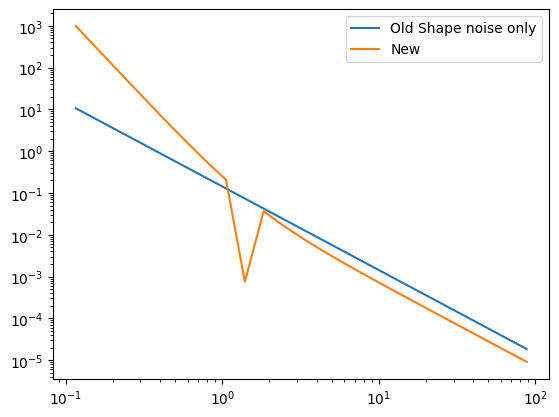

In [5]:
plt.figure()
plt.loglog(rp, Cov_SN_old_debug, label='Old Shape noise only')
plt.loglog(rp, np.diag(Cov_SN_Ups), label='New')
plt.legend()
plt.show()

#plt.figure()
#plt.semilogx(rp, np.diag(Cov_SN_Ups) / Cov_SN_old_debug, label='Old Shape noise only')
#plt.legend()
#plt.show()


Okay yeah that is a pretty good match (old cov is for Delta Sigma)

Now compute and load the covariance matrix using these adjusted jacknife samples.

In [5]:

cov_corr_dict = cs.evaluate_correlation_matrix(stat_list=['gm','gg', 'beta'],rmin=rp0,plots=0,data_dir='../data_for_Danielle/',  add_shape_noise='True', lens=lens, src=src)

In [6]:
print(cov_corr_dict['cov'].shape)
# Okay, so we know there are 15 rp bins for Upgg and Upgm, and one value of beta. Beta is at the end (checked)

(33, 33)


In [7]:
# Get rp from the sims and cut everything below rp0
#rp = np.loadtxt(
#    './test-HOD-PB00-z0.75-w1pz_cat-zRSD-model-5-gxm-sel-crossparticles-wtag-w1-rfact10-bin1-wp-logrp-pi-NJN-100.txt.upsilon')[:,0]
print(rp)
ind = next(j[0] for j in enumerate(rp) if j[1]>rp0)-1
rp_cut = rp[ind:]
print(rp_cut)

[ 0.11591284  0.15280288  0.20143342  0.26554097  0.35005117  0.46145732  0.60831922  0.80192091  1.05713764  1.39357881  1.83709466  2.42176242  3.19250463  4.20854074  5.54793718  7.31360558  9.64120984 12.70958983 16.75450244
 22.08673575 29.11598823 38.38234769 50.59778848 66.70087562 87.92887875]
[ 1.39357881  1.83709466  2.42176242  3.19250463  4.20854074  5.54793718  7.31360558  9.64120984 12.70958983 16.75450244 22.08673575 29.11598823 38.38234769 50.59778848 66.70087562 87.92887875]


We need to make sure everything is in the same units. Shadab's Upsilons are in units Mpc/h, whereas mine are in units Msol * h / pc^2. The factor to get them in the same units is rho_crit (in particular units).

In [8]:
mperMpc = 3.0856776*10**22
Msun = 1.989*10**30 # in kg
Gnewt = 6.67408*10**(-11) # kg^{-1}m^3 s^{-2}
c=2.99792458*10**(8) # m / s
rho_crit = 3. * 10**10 * mperMpc / (8. * np.pi * Gnewt * Msun) / 10**12  
# rho crit in Msol h^2 / Mpc / pc^2, to yield Upsilon_gg in Msol h / pc^2

OmegaM = 0.292

rpbins = len(rp_cut)

For Upsilon x beta, we should multiply by a single factor of rho_crit. For Upsilon x Upsilon, two factors.
In the case of Upsilon_gm, the sims stuff also has a missing factor of Omega_M whic we need to add.

Now load my analytical calculation of the covariance matrix (using in part Sukdheep's old Hankel transform code) - this is for comparison.

In [8]:
cov_Danielle = np.loadtxt('../txtfiles/joint_covariance_rp0=1.5_Oct2024.dat')

In [9]:
print(cov_Danielle.shape)
# Good, it's the same shape.

(33, 33)


Now let's get the simulations covariance matrix in the same units as mine, and also make a combined covariance matrix. Remember to multiply the elements from Shadab by rho_crit to get the right units. We also rescale to account for the difference between the volume that goes into our analytic covariance and the volume of Shadab's sim.

In [9]:
# Covariance goes like 1/volume, so multiply sims terms by sims_vol / us_vol to go to us_vol

vol_LSST_DESI = sp.volume(params, src, lens)

volume_factor = sims_vol / vol_LSST_DESI
print(volume_factor)

0.43070682763608437


In [10]:
# Do the rescaling to my units and LSST+DESI volume

cov_sims_myunits = np.zeros_like(cov_corr_dict['cov'])

# Ups_gm x Ups_gg
# Rescale by: volume factor, Omega_M*rho_crit**2 (= rho_M**2)
cov_sims_myunits[0:rpbins,0:rpbins] = rho_crit**2*volume_factor*OmegaM**2*cov_corr_dict['cov'][0:rpbins, 0:rpbins] # gm x gm

# Ups_gm x Ups_gg
# Rescale by: volume_factor, Omega_M*rho_crit (= rho_m), rho_crit
cov_sims_myunits[0:rpbins,rpbins:2*rpbins] = rho_crit**2*volume_factor*OmegaM*cov_corr_dict['cov'][0:rpbins, rpbins:2*rpbins] #gm x gg
cov_sims_myunits[rpbins:2*rpbins,0:rpbins] = rho_crit**2*volume_factor*OmegaM*cov_corr_dict['cov'][rpbins:2*rpbins, 0:rpbins] #gm x gg

# Ups_gg x Ups_gg
# Rescale by: volume_factor, rho_crit^2
cov_sims_myunits[rpbins:2*rpbins, rpbins:2*rpbins] = rho_crit**2*volume_factor*cov_corr_dict['cov'][rpbins:2*rpbins, rpbins:2*rpbins] #gg x gg

# Ups_gm x beta
# Recale by: volume factor, rho_crit*OmegaM
cov_sims_myunits[2*rpbins,0:rpbins] = rho_crit*OmegaM*volume_factor*cov_corr_dict['cov'][2*rpbins, 0:rpbins] # gm x beta
cov_sims_myunits[0:rpbins,2*rpbins] = rho_crit*OmegaM*volume_factor*cov_corr_dict['cov'][0:rpbins,2*rpbins] # gm x beta

# Ups_gg x beta from sims
# Rescale by: volume factor, rho_crit
cov_sims_myunits[2*rpbins,rpbins:2*rpbins] = rho_crit*volume_factor*cov_corr_dict['cov'][2*rpbins, rpbins:2*rpbins] # gg * beta
cov_sims_myunits[rpbins:2*rpbins,2*rpbins] = rho_crit*volume_factor*cov_corr_dict['cov'][rpbins:2*rpbins, 2*rpbins] # gg x beta

# beta x beta
# Rescale by volume factor
cov_sims_myunits[2*rpbins,2*rpbins] = volume_factor*cov_corr_dict['cov'][2*rpbins, 2*rpbins] # beta x beta

In [11]:
# Get the corresponding correlation matrix too:
corr_sims_myunits = np.zeros_like(cov_sims_myunits)
for i in range(0,len(cov_sims_myunits[0,:])):
    for j in range(0,len(cov_sims_myunits[:,0])):
        corr_sims_myunits[i,j] = cov_sims_myunits[i,j] / np.sqrt(cov_sims_myunits[i,i] * cov_sims_myunits[j,j])  

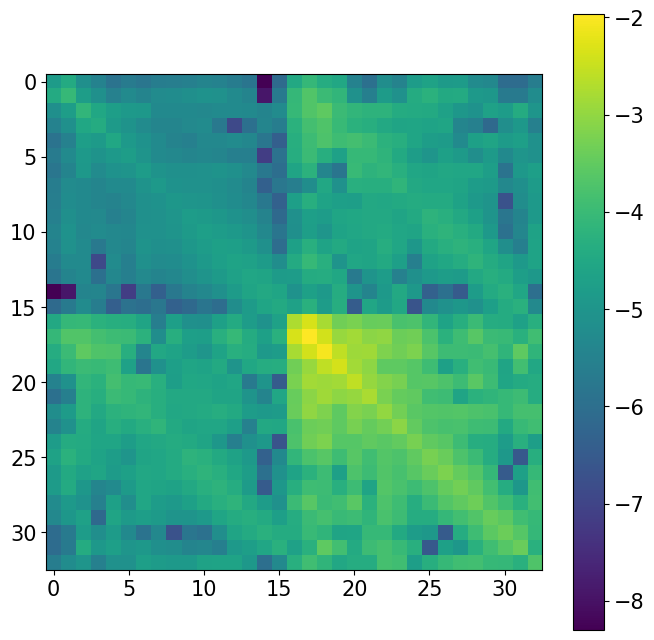

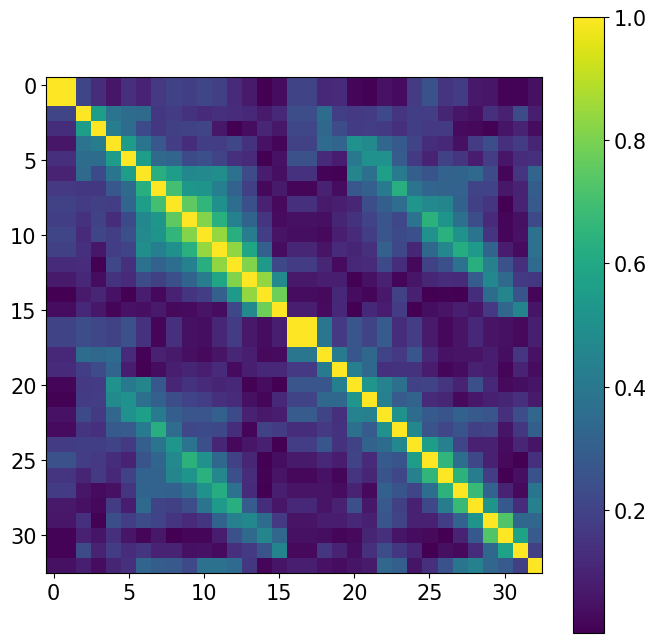

In [12]:
# Visualize the full covariance and correlation matrix - sims

plt.figure(figsize=[8,8])
plt.imshow(np.log10(np.abs(cov_sims_myunits)))
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
#plt.savefig('../plots/sims_cov_myunits_log10_wSN_rp0=1.5_Y10.pdf')
plt.show()

plt.figure(figsize=[8,8])
plt.imshow(np.abs(corr_sims_myunits))
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
cbar2 = plt.colorbar()
cbar2.ax.tick_params(labelsize=15)
#plt.savefig('../plots/sims_corr_myunits_wSN_rp0=1.5_Y10.pdf')
plt.show()

In [13]:
# Output the simulations covariance in my units in case we need this:

np.savetxt('../txtfiles/sims_cov_myunits_wSN_Jan25_LSSTY10.dat', cov_sims_myunits)

In [15]:
# Get the correlation matrix for the analytic covariance too:

# Get the corresponding correlation matrix too:
corr_Danielle = np.zeros_like(cov_Danielle)
for i in range(0,len(cov_Danielle[0,:])):
    for j in range(0,len(cov_Danielle[:,0])):
        corr_Danielle[i,j] = cov_Danielle[i,j] / np.sqrt(cov_Danielle[i,i] * cov_Danielle[j,j]) 

/tmp/ipykernel_382450/4042494676.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(cov_Danielle)))


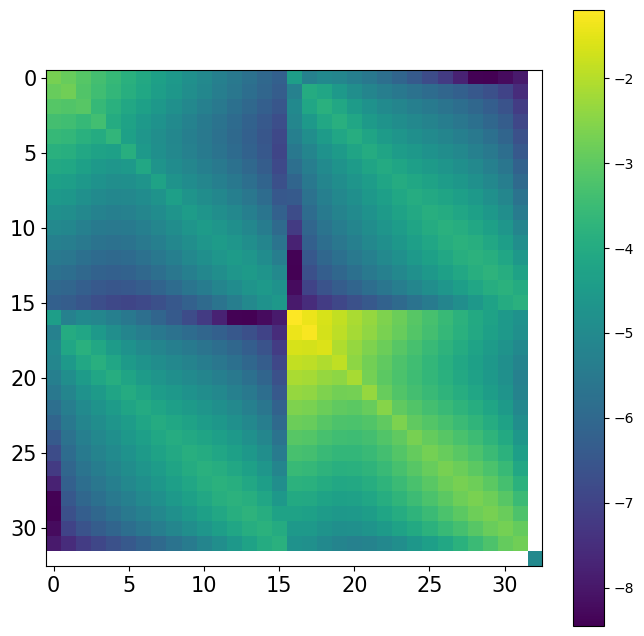

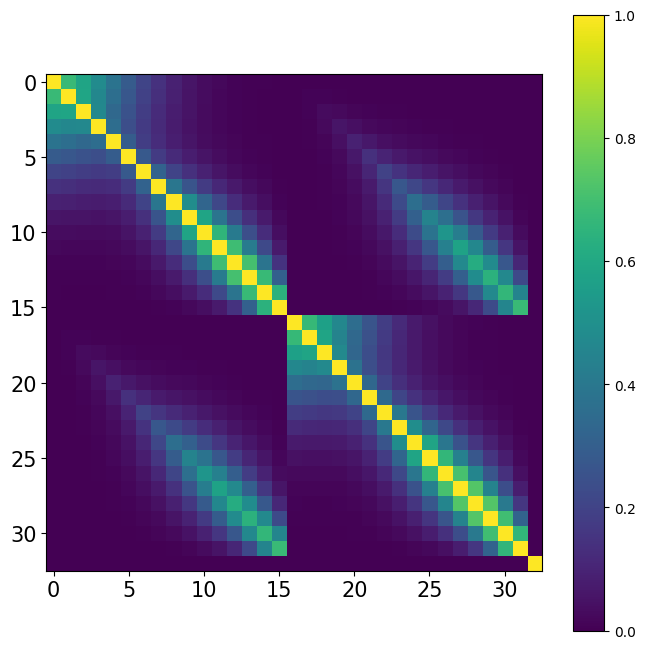

In [16]:
# Visualise the covariance and correlation matrix from my analytic code:

plt.figure(figsize=[8,8])
plt.imshow(np.log10(np.abs(cov_Danielle)))
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.colorbar()
#plt.savefig('../plots/analytic_cov_log10_rp=1.5.pdf')
plt.show()

plt.figure(figsize=[8,8])
plt.imshow(corr_Danielle)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.colorbar()
#plt.savefig('../plots/analytic_corr_rp=1.5.pdf')
plt.show()

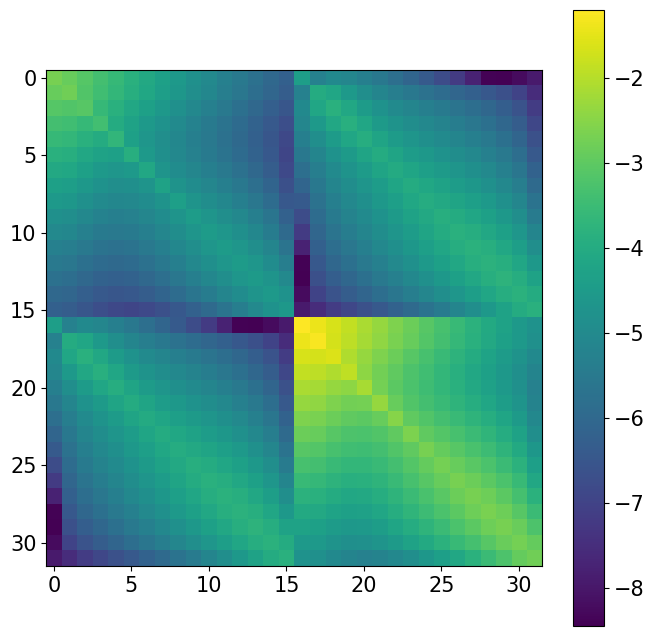

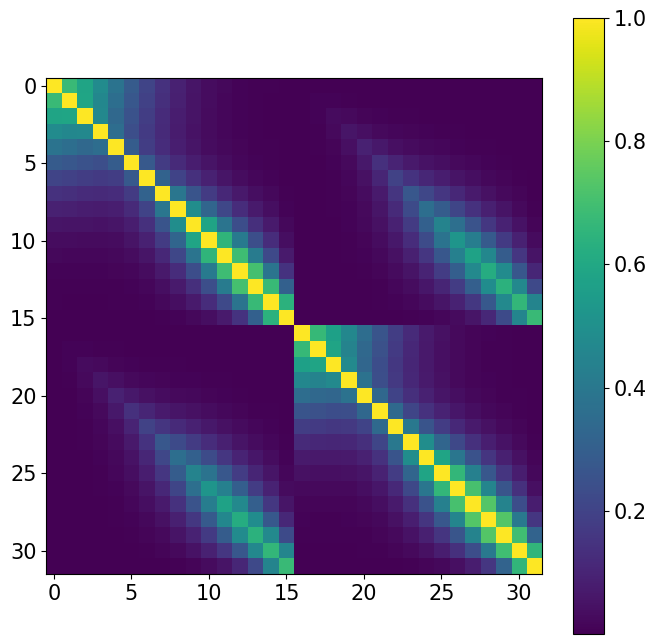

In [20]:
# Make plots of just the Upsilon_{gm} x Upsilon_gg part

# Visualise the covariance and correlation matrix from my analytic code:

plt.figure(figsize=[8,8])
plt.imshow(np.log10(np.abs(cov_Danielle[0:32,0:32])))
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
#plt.savefig('../plots/analytic_cov_log10_rp=1.5_Upsonly.pdf')
plt.show()

plt.figure(figsize=[8,8])
plt.imshow(corr_Danielle[0:32,0:32])
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
cbar2 = plt.colorbar()
cbar2.ax.tick_params(labelsize=15)
#plt.savefig('../plots/analytic_corr_rp=1.5_Upsonly.pdf')
plt.show()

Let's look at Cov(Ups_gm, Ups_gm) constructed from sims + shape noise vs mine. 

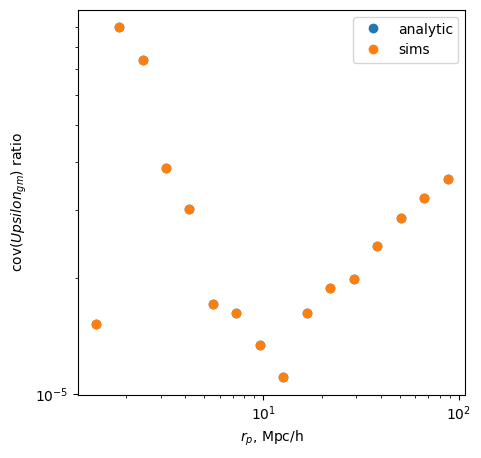

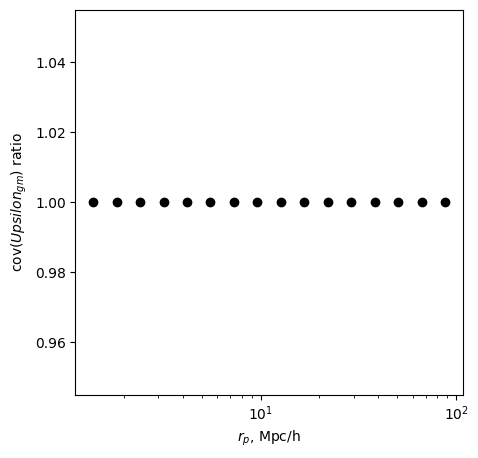

In [22]:
# Shadab diagonal Ups_gm, Ups_gm
#print np.diag(cov_corr_dict_gm['cov'][0:15,0:15])
# Mine diagonal Ups_gm, Ups_gm
#print np.diag(combined_cov[0:15,0:15])

plt.figure(figsize=[5,5])
plt.loglog(rp_cut, 
         np.diag(cov_sims_myunits[0:rpbins,0:rpbins]), 'o',label='analytic')
plt.loglog(rp_cut, (np.diag(cov_sims_myunits[0:rpbins,0:rpbins])), 'o',label='sims')
plt.ylabel("cov($Upsilon_{gm}$) ratio")
plt.xlabel("$r_p$, Mpc/h")
plt.legend()
plt.show()

plt.figure(figsize=[5,5])
plt.semilogx(rp_cut, 
         (np.diag(cov_sims_myunits[0:rpbins,0:rpbins])) / (np.diag(cov_sims_myunits[0:rpbins,0:rpbins])), 
         'ko')
plt.ylabel("cov($Upsilon_{gm}$) ratio")
plt.xlabel("$r_p$, Mpc/h")
plt.show()

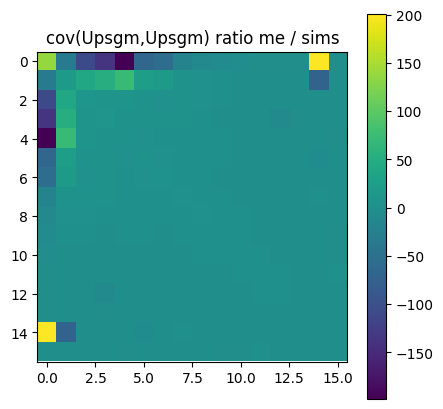

In [23]:
# How does this look off the diagonal? 
covUpsgm_ratio = cov_Danielle[0:rpbins,0:rpbins] / (cov_sims_myunits[0:rpbins,0:rpbins])

plt.figure(figsize=[5,5])
plt.title('cov(Upsgm,Upsgm) ratio me / sims')
plt.imshow(covUpsgm_ratio)
plt.colorbar()
plt.show()

In principle, my cov(Upsilon_gg, Upsilon_gg) and Shadab's cov(Upsilon_gg, Upsilon_gg) should agree (modulo noise in the sims and non-Gaussian terms).

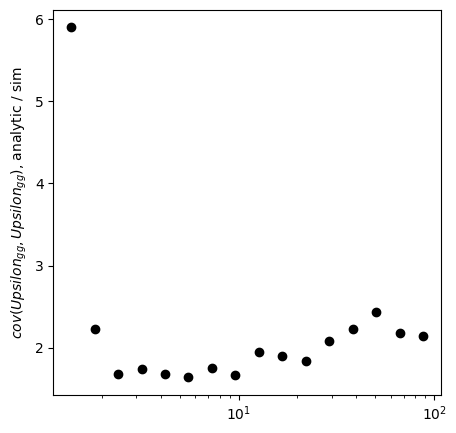

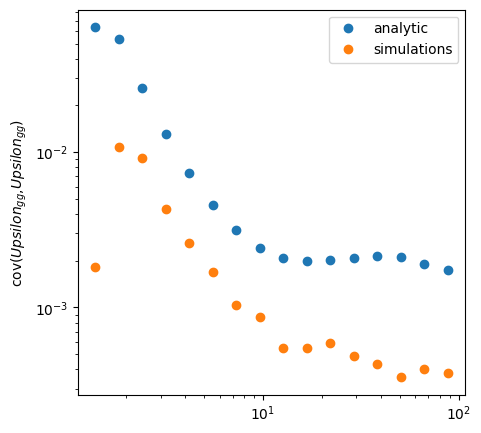

In [24]:
# Shadab diagonal Ups_gg, Ups_gg
#print np.diag(cov_corr_dict_gg['cov'][0:15,0:15])
# Mine diagonal Ups_gm, Ups_gm
#print np.diag(combined_cov[15:30,15:30])

plt.figure(figsize=[5,5])
plt.semilogx(rp_cut, 
         np.sqrt(np.diag(cov_Danielle[rpbins:2*rpbins,rpbins:2*rpbins]) / np.diag(cov_sims_myunits[rpbins:2*rpbins,rpbins:2*rpbins])), 'ko')
plt.ylabel('$cov(Upsilon_{gg}, Upsilon_{gg})$, analytic / sim')
plt.show()

plt.figure(figsize=[5,5])
plt.loglog(rp_cut, 
         np.diag(cov_Danielle[rpbins:2*rpbins,rpbins:2*rpbins]), 'o', label='analytic')
plt.loglog(rp_cut, np.diag(cov_sims_myunits[rpbins:2*rpbins,rpbins:2*rpbins]), 'o', label='simulations')
plt.ylabel("cov($Upsilon_{gg}$,$Upsilon_{gg}$)")
plt.legend()
plt.show()

/tmp/ipykernel_382450/3573090431.py:5: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(covUpsgg_ratio))


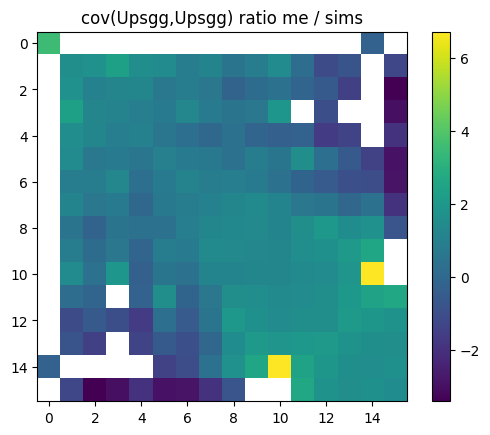

In [25]:
# How does this look off the diagonal? 
covUpsgg_ratio = cov_Danielle[rpbins:2*rpbins,rpbins:2*rpbins] / (cov_sims_myunits[rpbins:2*rpbins,rpbins:2*rpbins])
plt.figure()
plt.title('cov(Upsgg,Upsgg) ratio me / sims')
plt.imshow(np.log(covUpsgg_ratio))
plt.colorbar()
plt.show()

In [26]:
# My cov(beta, beta) is only shot noise whereas Shadab's should be shot noise and cosmic variance
print("Shadab, sigma(beta)=", np.sqrt(cov_sims_myunits[2*rpbins,2*rpbins]))
print("My sigma(beta)=", np.sqrt(cov_Danielle[2*rpbins,2*rpbins]))

Shadab, sigma(beta)= 0.014092736084911163
My sigma(beta)= 0.003026978689446642


Right so my cov(Upsilon_gg, Upsilon_gg) should agree with Shadab's but the error on the diagonal is larger by about 2 (meaning the covariance is off by about 4). What's wrong?

let's also look at the two versions of cov(Upgm,Upgg)

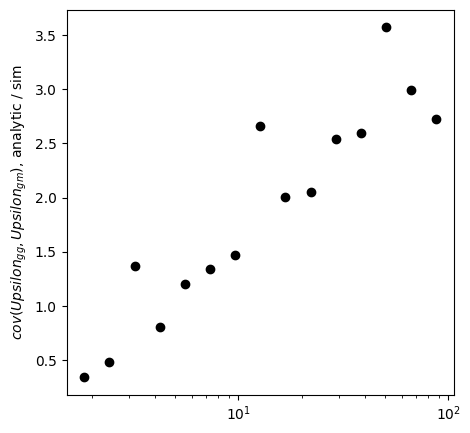

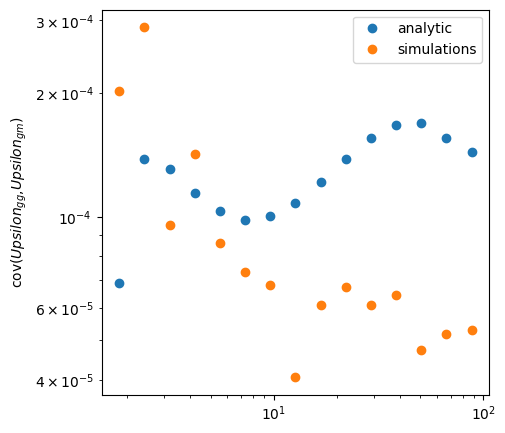

In [25]:
plt.figure(figsize=[5,5])
plt.semilogx(rp_cut, 
         np.diag(cov_Danielle[rpbins:2*rpbins,0:rpbins]) / np.diag(cov_sims_myunits[rpbins:2*rpbins,0:rpbins]), 'ko')
plt.ylabel('$cov(Upsilon_{gg}, Upsilon_{gm})$, analytic / sim')
plt.show()

plt.figure(figsize=[5,5])
plt.loglog(rp_cut, 
         np.diag(cov_Danielle[rpbins:2*rpbins,0:rpbins]), 'o', label='analytic')
plt.loglog(rp_cut, np.diag(cov_sims_myunits[rpbins:2*rpbins,0:rpbins]), 'o', label='simulations')
plt.ylabel("cov($Upsilon_{gg}$,$Upsilon_{gm}$)")
plt.legend()
plt.show()

/tmp/ipykernel_354029/903792274.py:5: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(covUpsgggm_ratio))


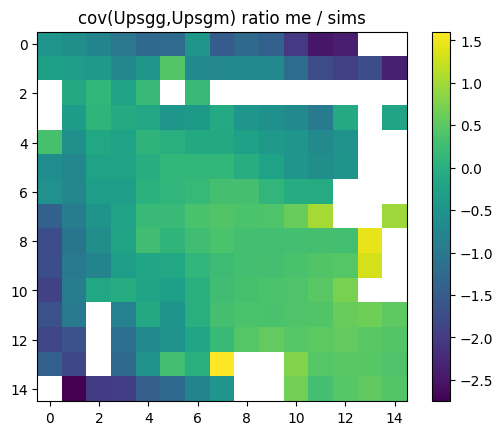

In [26]:
# How does this look off the diagonal? 
covUpsgggm_ratio = cov_Danielle[15:30,0:15] / (cov_sims_myunits[15:30,0:15])
plt.figure()
plt.title('cov(Upsgg,Upsgm) ratio me / sims')
plt.imshow(np.log10(covUpsgggm_ratio))
plt.colorbar()
plt.show()